In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import os.path as op
import numpy as np
import nibabel as nib

from pyhrf.boldsynth.hrf import getCanoHRF
from pyhrf.ndarray import xndarray
from pyhrf.plot import autocrop

archives = op.join('/media', 'aina', 'MISTIS', 'Data', 'BOLD data', 'Data_GIN_Em')
vem_dir = 'vem_mmvsms_8conds_9sess_lr_hyp_vh0.001_gh100000'
fig_dir = vem_dir + '_figs'
if not op.exists(fig_dir): os.makedirs(fig_dir)

subjects = ['283', '271', '291', '292', '274', '284', '288', '289', '273']
brf_n = 'jde_vem_asl_brf.nii'
brls_n = 'jde_vem_asl_brls.nii'
labels_n = 'jde_vem_asl_labels.nii'

In [3]:
# Parameters
tr = 2.
dt = tr / 2.
dur = 18.
n_scans = 126
taxis = np.arange(0., dur + dt, dt)
_, brf = getCanoHRF(dur, dt)
roi_hrf_list = np.array([1, 2])

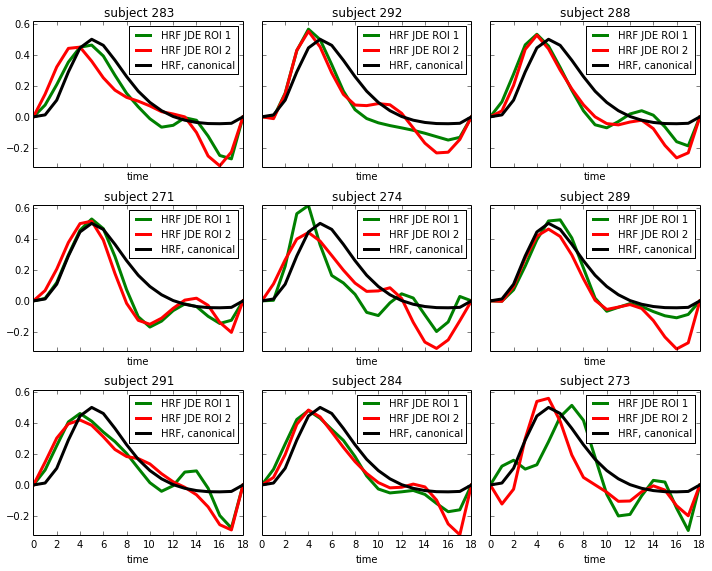

In [4]:
color = ['g', 'r']
f, ax = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
#f.suptitle('Estimated HRFs from V1 left and right', fontsize=14, fontweight='bold')
for isub, subject in enumerate(subjects[:]):
    brf_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, brf_n)
    brf_v0 = xndarray.load(brf_fn)
    for roi_hrf in roi_hrf_list:
        brf_v = brf_v0.sub_cuboid(ROI=roi_hrf)
        ax[isub%3, isub/3].plot(brf_v.axes_domains['time'], brf_v.data, color[roi_hrf - 1], linewidth=3,
                                label='HRF JDE ROI '+str(roi_hrf))
    ax[isub%3, isub/3].plot(brf_v.axes_domains['time'], brf, 'k', linewidth=3, label='HRF, canonical')
    ax[isub%3, isub/3].axis('tight')
    ax[isub%3, isub/3].set_xlabel('time')
    ax[isub%3, isub/3].set_title('subject ' + subject)
    ax[isub%3, isub/3].legend(prop={'size':10})
    fig_fn = op.join(fig_dir, 'vem_brf_%s_roi%d.png' % (subject, roi_hrf))
f.tight_layout()
f.savefig(fig_fn)
autocrop(fig_fn)


In [5]:
from pyhrf.paradigm import Paradigm

paradigm_l_fn = op.join(archives, 'paradigm_data', 'visual_block1b.csv')
paradigm_r_fn = op.join(archives, 'paradigm_data', 'visual_block2b.csv')

paradigm_l = Paradigm.from_csv(paradigm_l_fn)
paradigm_r = Paradigm.from_csv(paradigm_r_fn)
labels = paradigm_l.get_stimulus_names() + paradigm_r.get_stimulus_names()
print labels

['c5_d', 'c3_d', 'c1_d', 'c9_d', 'c3_g', 'c5_g', 'c1_g', 'c9_g']


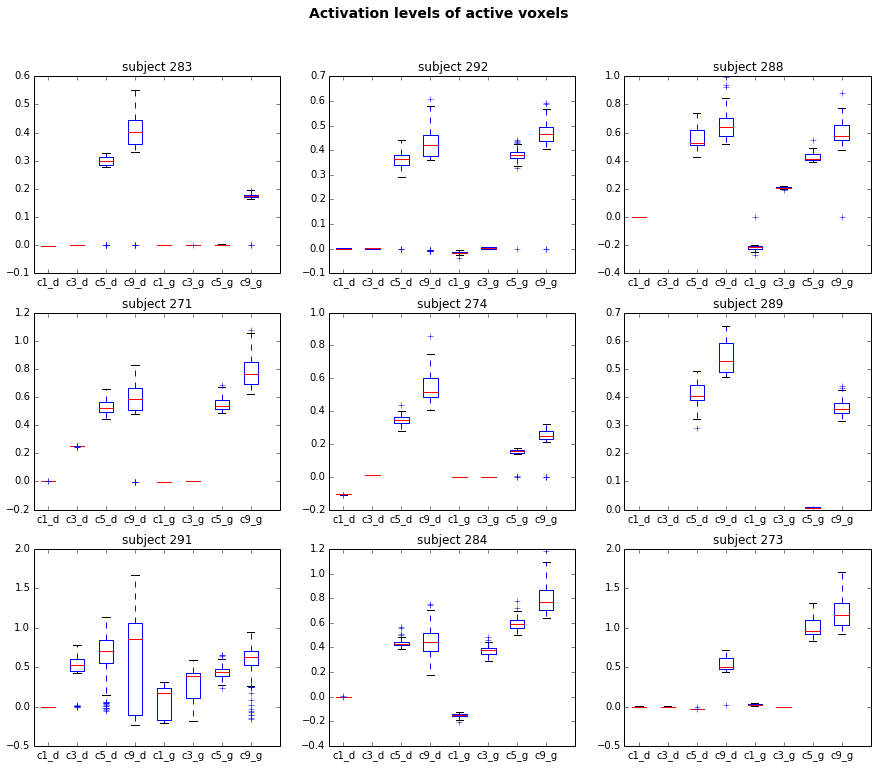

In [29]:
from collections import OrderedDict

# Choose threshold for activated voxels p(q_j=1)
th = 0.5
labels = ['c1_d', 'c3_d', 'c5_d', 'c9_d', 'c1_g', 'c3_g', 'c5_g', 'c9_g']
bsubj = OrderedDict([])
for cond in labels:
    bsubj[cond] = np.array([])
bsubj_m = bsubj.copy()

f, ax = plt.subplots(3, 3, figsize=(15, 12)) #, sharex=True, sharey=True)
f.suptitle('Activation levels of active voxels', fontsize=14, fontweight='bold')
for isub, subject in enumerate(subjects[:]):
    #print subject
    brls_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, brls_n)
    labs_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, labels_n)
    brls_v = xndarray.load(brls_fn)
    labs_v = xndarray.load(labs_fn)    
    brls = []
    for ic, cond in enumerate(labels):
        brls_c = brls_v.sub_cuboid(condition=cond).data
        labs_c = labs_v.sub_cuboid(condition=cond).data[:, :, :, 1]
        brls.append(brls_c[labs_c>th])
        bsubj[cond] = np.append(bsubj[cond], np.array(brls_c[labs_c>th]))
        bsubj_m[cond] = np.append(bsubj_m[cond], np.mean((brls_c[labs_c>th])))
    ax[isub%3, isub/3].boxplot(brls)
    ax[isub%3, isub/3].set_title('subject ' + subject)
    plt.sca(ax[isub%3, isub/3])
    plt.xticks(range(1, 10), labels)
    
#plt.setp(ax, xticks=range(1, 10), xticklabels=labels)

([<matplotlib.axis.XTick at 0x7fc2dc2a7c90>,
 <a list of 8 Text xticklabel objects>)

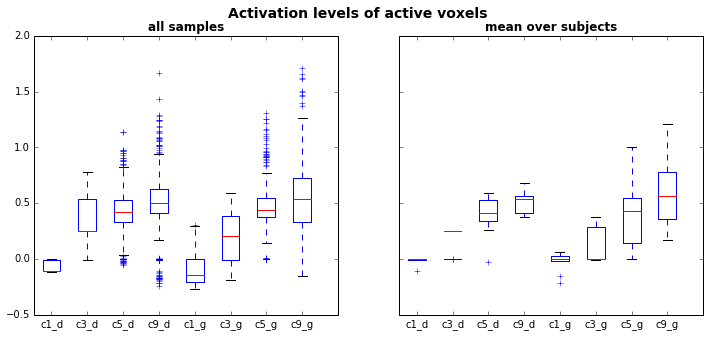

In [46]:
s, s2 = [], []
for cond in bsubj:
    s.append(bsubj[cond])
    s2.append(bsubj_m[cond])
f, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
f.suptitle('Activation levels of active voxels', fontsize=14, fontweight='bold')
ax[0].set_title('all samples', fontsize=12, fontweight='bold')
ax[0].boxplot(s)
plt.sca(ax[0])
plt.xticks(range(1, 10), labels)
ax[1].set_title('mean over subjects', fontsize=12, fontweight='bold')
ax[1].boxplot(s2)
plt.sca(ax[1])
plt.xticks(range(1, 10), labels)

Why do we have negative values? Maybe a baseline problem. 
Michel takes the 100 better voxels, does the mean, and gets a value per subject. Boxplot shows this.
Compare level response for luminance 9% (regressor) to std of residuals.
In this region we have SNR 20 (mean V1 / std voxel of WM). What do we have in CS?
tSNR = around 60 in V1 (we had more than 200 voxels), 20 in CS and LGN.

Compare with results of GLM and GLM using your estimated HRF. 
Compare to GLM with estimated HRF with leave one run out.

/home/aina/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: underflow encountered in multiply
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


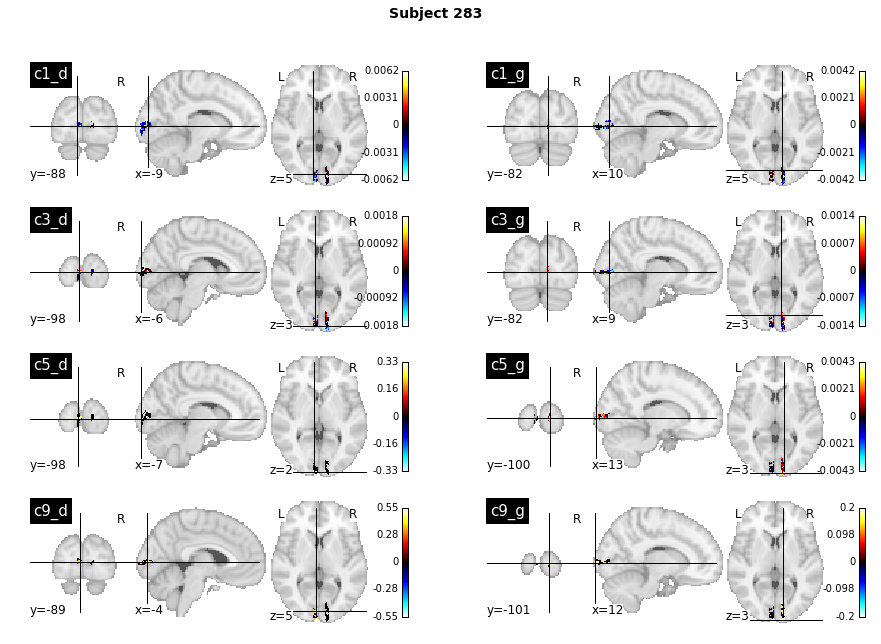

In [47]:
from nipy.labs.viz import plot_map, cm, mni_sform
from nilearn.plotting import plot_stat_map

for isub, subject in enumerate(subjects[:1]):
    brls_fn = op.join(archives, 'MAP-VS-' + subject, vem_dir, brls_n)
    brls = nib.load(brls_fn)
    #brls_v = brls.get_data()
    affine = brls.get_affine()
    brls = xndarray.load(brls_fn)
    
    f, ax = plt.subplots(4, 2, figsize=(15, 10))
    f.suptitle('Subject ' + subject, fontsize=14, fontweight='bold')
    n_cond = 8
    for icond in xrange(n_cond):
        brls_c = brls.sub_cuboid(condition=labels[icond]).data
        img = nib.Nifti1Image(brls_c, affine=affine)
        fn = 'tmp_file.nii.gz'
        nib.save(img, fn)
        data_shape_mni = img.get_data().shape * np.abs(np.diag(affine[:3, :3]))
        ind_max = np.unravel_index(img.get_data().argmax(), img.get_data().shape)
        (x, y, z) = np.dot(ind_max, affine[:3, :3]) + affine[:3, 3]
        plot_stat_map(img, title=labels[icond], figure=f,
                      axes=ax[icond%(n_cond/2), icond/(n_cond/2)], cut_coords=(x, y, z))


In [392]:
plot_stat_map?

<function __main__.show_image>

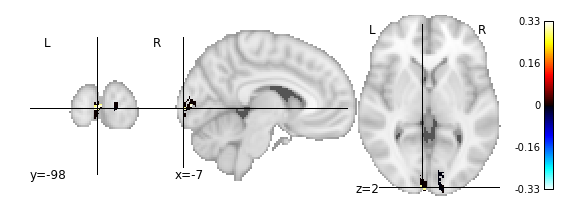

In [422]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML
%pylab inline

def show_image(x, y, z, path ):
    img = nib.load(path)
    plot_stat_map(img, cut_coords=(x, y, z))


subject = subjects[0]
icond = 0

brls = nib.load(op.join(archives, 'MAP-VS-' + subject, vem_dir, brls_n))
img = nib.Nifti1Image(brls.get_data()[:, :, :, icond], affine=affine)
fn = 'tmp_file.nii.gz'
nib.save(img, fn)

affine = brls.get_affine()
data_shape_mni = img.get_data().shape * np.abs(np.diag(affine[:3, :3]))
ind_max = np.unravel_index(img.get_data().argmax(), img.get_data().shape)
ind_max_mni = np.dot(ind_max, affine[:3, :3]) + affine[:3, 3]

interact( show_image, path = fn,
         x=widgets.IntSliderWidget(min=-data_shape_mni[0], max=data_shape_mni[0], step=1, value=ind_max_mni[0]),
         y=widgets.IntSliderWidget(min=-data_shape_mni[1], max=data_shape_mni[1], step=1, value=ind_max_mni[1]),
         z=widgets.IntSliderWidget(min=-data_shape_mni[2], max=data_shape_mni[2], step=1, value=ind_max_mni[2]))

In [2]:
"""from pyhrf.core import FmriData
bold_fn = op.join(archives, 'MAP-VS-' + subject, 'EPI1_501_EPI_ParkCS',
                  'wrrMAP-VS-' + subject + '_EPI_ParkCS_1_5_SENSE.nii')
#bold = nib.load(bold_fn).get_data()
#print bold.shape
def load_data(archives, subject, tr):
    # Folder and file names
    data_fn = op.join(archives, 'MAP-VS-' + subject, 'EPI1_501_EPI_ParkCS',
                  'wrrMAP-VS-' + subject + '_EPI_ParkCS_1_5_SENSE.nii')
    paradigm_fn = op.join(archives, 'paradigm_data', 'visual_block1b.csv')
    dilate = True
    roi_mask_fn = op.join(archives, 'MAP-VS-' + subject, 'roi_visual_dilated_ofs_lr.nii')
    # Load data
    fdata = FmriData.from_vol_files(roi_mask_fn, paradigm_fn, [data_fn], tr)
    return fdata
"""

"from pyhrf.core import FmriData\nbold_fn = op.join(archives, 'MAP-VS-' + subject, 'EPI1_501_EPI_ParkCS',\n                  'wrrMAP-VS-' + subject + '_EPI_ParkCS_1_5_SENSE.nii')\n#bold = nib.load(bold_fn).get_data()\n#print bold.shape\ndef load_data(archives, subject, tr):\n    # Folder and file names\n    data_fn = op.join(archives, 'MAP-VS-' + subject, 'EPI1_501_EPI_ParkCS',\n                  'wrrMAP-VS-' + subject + '_EPI_ParkCS_1_5_SENSE.nii')\n    paradigm_fn = op.join(archives, 'paradigm_data', 'visual_block1b.csv')\n    dilate = True\n    roi_mask_fn = op.join(archives, 'MAP-VS-' + subject, 'roi_visual_dilated_ofs_lr.nii')\n    # Load data\n    fdata = FmriData.from_vol_files(roi_mask_fn, paradigm_fn, [data_fn], tr)\n    return fdata\n"